# Traffic Light Controller for a Single 4-Way Road Intersection using Soft Actor Critic algorithm

## Installations and setup

We use SUMO (Simulation of Urban MObility) for simulating the traffic environment

In [1]:
!sudo add-apt-repository -y ppa:sumo/stable
!sudo apt-get update -y
!sudo apt-get install -y sumo sumo-tools sumo-doc
!pip install sumolib traci
!pip install torchviz
!pip install stable-baselines3 gym

Repository: 'deb https://ppa.launchpadcontent.net/sumo/stable/ubuntu/ jammy main'
Description:
SUMO is a highly portable, microscopic traffic simulation package designed to handle large road networks. SUMO is open source, licensed under the EPLv2.
More info: https://launchpad.net/~sumo/+archive/ubuntu/stable
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/sumo-ubuntu-stable-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/sumo-ubuntu-stable-jammy.list
Adding key to /etc/apt/trusted.gpg.d/sumo-ubuntu-stable.gpg with fingerprint 7604B28616B7E70EC0E6D840C32412BB1ADB414B
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:5 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]
Get:6 http://

In [2]:
import os
os.environ["SUMO_HOME"] = "/usr/share/sumo"

## Imports

In [3]:
import traci
import sumolib
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot

import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from gymnasium.spaces import Box, Dict, Discrete
import xml.etree.ElementTree as ET

## Customising the network and route files

In [4]:
# Network file
net_file = "/usr/share/sumo/tools/game/fkk_in/ingolstadt.net.xml.gz"

# Route file
route_file = "/usr/share/sumo/tools/game/fkk_in/fkk_in.rou.xml"

In [5]:
def add_emergency_vehicle_type_to_route(input_route_file, output_route_file=None):
    """
    Add an emergency vehicle type to the vTypeDistribution block in a SUMO .rou.xml file.
    
    Parameters:
    input_route_file (str): Path to the input SUMO route file (.rou.xml).
    output_route_file (str): Path to save the modified SUMO route file. If None, the original file is overwritten.
    """
    
    # Parse the XML file
    tree = ET.parse(input_route_file)
    root = tree.getroot()

    # Find the <vTypeDistribution> block
    vtype_distribution = root.find(".//vTypeDistribution")

    if vtype_distribution is None:
        print("vTypeDistribution block not found.")
        return

    # Check if the emergency vType already exists
    existing_vtype = vtype_distribution.find(".//vType[@id='emergency']")
    
    if existing_vtype is None:
        # If not found, create a new vType for emergency vehicles
        emergency_vtype = ET.Element("vType")
        emergency_vtype.set("id", "emergency")
        emergency_vtype.set("length", "5.0")
        emergency_vtype.set("minGap", "2.0")
        emergency_vtype.set("guiShape", "emergency")
        emergency_vtype.set("color", "0,0,1")  # Blue color
        emergency_vtype.set("probability", "1")  # Set probability for emergency vehicles

        # Add the new vType to the vTypeDistribution block
        vtype_distribution.append(emergency_vtype)
        print("Added emergency vehicle type to vTypeDistribution.")
    else:
        # Update the existing emergency vType
        existing_vtype.set("length", "5.0")
        existing_vtype.set("minGap", "2.0")
        existing_vtype.set("guiShape", "emergency")
        existing_vtype.set("color", "0,0,1")  # Blue color
        existing_vtype.set("probability", "1")
        print("Updated existing emergency vehicle type in vTypeDistribution.")
    
    # If no output file is specified, overwrite the original file
    if output_route_file is None:
        output_route_file = input_route_file

    # Write the modified XML to the output file
    tree.write(output_route_file, encoding="UTF-8", xml_declaration=True)
    print(f"Route file saved to: {output_route_file}")

In [6]:
input_route_file = route_file
output_route_file = None  # If None, the original file will be overwritten

add_emergency_vehicle_type_to_route(input_route_file, output_route_file)

Added emergency vehicle type to vTypeDistribution.
Route file saved to: /usr/share/sumo/tools/game/fkk_in/fkk_in.rou.xml


## Utilities

In [7]:
# Acceptable noise levels
noise_limits = {
    "industrial": {
        "daytime": 75,
        "nighttime": 70
    },
    "commercial": {
        "daytime": 65,
        "nighttime": 55
    },
    "residential": {
        "daytime": 55,
        "nighttime": 45
    }
}

# Lane segregation lists
incoming_vehicle_lanes = [
    "737320747#4.146_4",
    "737320747#4.146_3",
    "737320747#4.146_2",
    "737320747#4_3",
    "737320747#4_2",

    "137246371#1_2",
    "137246371#2_2",
    "30399663#0_3",
    "30399663#0_2",
    "30399663#1_4",
    "30399663#1_3",
    "30399663#1_2",

    "148050455#0_1",
    "148050455#1_2",
    "148050455#1_3",

    "gneE12_0",
    "gneE12_1",
    "gneE12_2",
    "29119850.76_2",
    "29119850.76_3",
    "29119850.76_4",
    "29119850_2",
    "29119850_3"
]
outgoing_vehicle_lanes = [
    "54169280#0_2",
    "54169280#0_3",
    "54169280#1_2",
    "54169280#1_3",

    "30399326#1_0",
    "30399326#1.23_0",
    "-30399663#1_0",
    "-30399663#0_0",
    "-137246371#2_3",
    "-137246371#2_2",
    "-137246371#1_3",
    "-137246371#1_2",

    "-148050455#0_1",
    "-148050455#1_2",

    "28639688#1_3",
    "28639688#1_2",
    "28639688#2_3",
    "28639688#2_2",
    "116687469#0_3",
    "116687469#0_2"
]
incoming_pedestrian_lanes = [
    "737320747#4.146_1",
    "737320747#4_1",

    "gneE59_1",
    "gneE60_1",
    "gneE61_1",
    "137246371#1_1",
    "137246371#2_1",
    "30399663#0_1",
    "30399663#1_1",

    "148050455#1_1",

    "29119850_1",
    "29119850.76_1"
]
outgoing_pedestrian_lanes = [
    "54169280#0_1",
    "54169280#1_1",

    "-gneE61_1",
    "-gneE60_1",
    "gneE59.16_1",
    "-137246371#2_1",
    "-137246371#1_1",

    "-148050455#1_1",

    "28639688#1_1",
    "28639688#2_1",
    "116687469#0_1"
]
vehicle_lanes = incoming_vehicle_lanes + outgoing_vehicle_lanes 
pedestrian_lanes = incoming_pedestrian_lanes + outgoing_pedestrian_lanes

def get_current_phase_duration_limits(visibility):
    max_phase_durations_sec = {
        0: 600,
        1: 600,
        2: 600,
        3: 600,
        4: 600,
        5: 600,
        6: 600,
        7: 600,
        8: 600,
        9: 600,
        10: 600,
        11: 600,
        12: 600,
        13: 600,
        14: 600
    }

    min_phase_durations_sec = {
        0: 60,
        1: 30,
        2: 5,
        3: 60,
        4: 30,
        5: 5,
        6: 60,
        7: 30,
        8: 5,
        9: 60,
        10: 30,
        11: 5,
        12: 60,
        13: 30,
        14: 5
    }
    
    reduction = 1 - float(np.exp(-(visibility/13)))
    for i in range(15):
        max_phase_durations_sec[i]  = max_phase_durations_sec[i] - ((max_phase_durations_sec[i]/2)*reduction)
        min_phase_durations_sec[i]  = min_phase_durations_sec[i] - ((min_phase_durations_sec[i]/2)*reduction)
    return (min_phase_durations_sec, max_phase_durations_sec)
        

# Get the appropriate device (CUDA or CPU)
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def dict_to_sorted_numpy_array(dictionary, data_type):
    # Sort the keys
    sorted_keys = sorted(dictionary.keys())
    # Create a list of values in sorted order
    sorted_values = [dictionary[key] for key in sorted_keys]
    # Convert to numpy array
    np_array = np.array(sorted_values, dtype=data_type)
    return np_array

def set_traffic_light_logic(current_phase):
    traffic_light_ids = traci.trafficlight.getIDList()
    
    phases=[]
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='rrGGGGrrrrrrrrrrrr', minDur=10000.0, maxDur=10000.0, name='1'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='rrGyyyrrrrrrrrrrrr', minDur=10000.0, maxDur=10000.0, name='2'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='rrGrrrrrrrrrrrrrrr', minDur=10000.0, maxDur=10000.0, name='3'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='GGGGrrrrrrrrrrrrrr', minDur=10000.0, maxDur=10000.0, name='4'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='yyGyrrrrrrrrrrrrrr', minDur=10000.0, maxDur=10000.0, name='5'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='rrGrrrrrrrrrrrrrrr', minDur=10000.0, maxDur=10000.0, name='6'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='rrGGrrrrrrrGGGrrGr', minDur=10000.0, maxDur=10000.0, name='7'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='rrGyrrrrrrryGyrrGr', minDur=10000.0, maxDur=10000.0, name='8'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='rrGrrrrrrrrrrrrrrr', minDur=10000.0, maxDur=10000.0, name='9'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='rrGrrrGGGrrrrrGrrG', minDur=10000.0, maxDur=10000.0, name='10'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='rrGrrryyyrrrrrGrry', minDur=10000.0, maxDur=10000.0, name='11'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='rrGrrrrrrrrrrrrrrr', minDur=10000.0, maxDur=10000.0, name='12'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='rrGrGrrrGGGrrrrGrr', minDur=10000.0, maxDur=10000.0, name='13'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='rrGryrrryyGrrrryrr', minDur=10000.0, maxDur=10000.0, name='14'))
    phases.append(traci.trafficlight.Phase(duration=10000.0, state='rrGrrrrrrrrrrrrrrr', minDur=10000.0, maxDur=10000.0, name='15'))
    
    new_program = traci.trafficlight.Logic(programID='Pnew', type=0, currentPhaseIndex=current_phase, phases=phases, subParameter={})

    traci.trafficlight.setProgramLogic(traffic_light_ids[1], new_program)
    
def get_road_visibility(x, x_max, x1, x2, x3):
    # x --> current episode step (int)
    # x_max --> max episode step (int)
    # x1 --> control parameter 1 varying from 0 to 1 (float)
    # x2 --> control parameter 2 varying from 0 to 1 (float)
    # x3 --> control parameter 3 varying from 0 to 1 (float)
    s1 = math.sin(((0.1*x)/(3*x_max))*(((100*x)/x_max)-(300*x1)))
    s2 = math.sin(((0.3*x)/(3*x_max))*(((100*x)/x_max)-(300*x2)))
    s3 = math.sin(((2*x)/(3*x_max))*(((100*x)/x_max)-(300*x3)))
    return 25 + 12*s1 + 12*s2 + s3

def is_point_in_polygon(x, y, polygon):
    """
    Determines if a point (x, y) is inside a polygon.

    Args:
        x (float): X-coordinate of the point.
        y (float): Y-coordinate of the point.
        polygon (list): List of tuples representing the polygon's vertices.

    Returns:
        bool: True if the point is inside the polygon, False otherwise.
    """
    n = len(polygon)
    inside = False

    p1x, p1y = polygon[0]
    for i in range(1, n + 1):
        p2x, p2y = polygon[i % n]
        if min(p1y, p2y) < y <= max(p1y, p2y):
            if x <= max(p1x, p2x):
                if p1y != p2y:
                    x_intersection = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                if p1x == p2x or x <= x_intersection:
                    inside = not inside
        p1x, p1y = p2x, p2y

    return inside

## Creating a custom gym environment

In [8]:
class RoadIntersectionEnv(gym.Env):
    
    def __init__(self, randomised_starts, init_tl_phase, vis_factor_1, vis_factor_2, vis_factor_3, daytime_indicator):
        # User provided parameters are ignored if randomised_starts is set to True
        
        # Network file
        self.net_file = "/usr/share/sumo/tools/game/fkk_in/ingolstadt.net.xml.gz"
        
        # Route file
        self.route_file = "/usr/share/sumo/tools/game/fkk_in/fkk_in.rou.xml"
        
        self.inlane_vehicle_start_time = {}
        self.outlane_vehicle_start_time = {}
        
        self.randomised_starts = randomised_starts
        self.init_tl_phase = init_tl_phase
        
        self.area_type = "commercial"
        
        self.max_episode_steps = 5000
        
        self.daytime_change_frequency = 1500 # Changing daytime flag after every 1500 steps
        
        self.num_rows, self.num_columns, self.x_ref, self.y_ref = self.get_frame_dimensions()
        
        # Initialising episode_steps and cumulative_reward
        self.episode_steps = 0
        self.cumulative_reward = 0
        
        # Path to SUMO binary
        self.sumoBinary = "/usr/bin/sumo"
        self.sumoCmd = [self.sumoBinary, "--time-to-teleport=-1", "-c", "/usr/share/sumo/tools/game/fkk_in.sumocfg"]
        
        # Start the SUMO simulation
        if not self.randomised_starts:
            traci.start(self.sumoCmd)
            set_traffic_light_logic(self.init_tl_phase)
            self.vis_factor_1 = vis_factor_1
            self.vis_factor_2 = vis_factor_2
            self.vis_factor_3 = vis_factor_3
            self.daytime_indicator = daytime_indicator
        else:
            self.random_start_with_warm_up()
        
        self.junction_shape = traci.junction.getShape("gneJ21")
        
        # Define the observation space using gym.spaces.Dict
        self.observation_space = Dict({
            "halted_vehicle_counts": Box(low=0, high=np.inf, shape=(len(vehicle_lanes),), dtype=np.int32),
            "tot_vehicle_counts": Box(low=0, high=np.inf, shape=(len(vehicle_lanes),), dtype=np.int32),
            "normal_vehicle_sum_waiting_time": Box(low=0, high=np.inf, shape=(len(vehicle_lanes),), dtype=np.float32),
            "priority_vehicle_sum_waiting_time": Box(low=0, high=np.inf, shape=(len(vehicle_lanes),), dtype=np.float32),
            "vehicle_pos_grid": Box(low=0, high=1, shape=(self.num_rows, self.num_columns), dtype=np.int32),
            "vehicle_speed_grid": Box(low=0, high=np.inf, shape=(self.num_rows, self.num_columns), dtype=np.float32),
            "vehicle_acc_grid": Box(low=-np.inf, high=np.inf, shape=(self.num_rows, self.num_columns), dtype=np.float32),
            "priority_vehicle_ind_grid": Box(low=0, high=1, shape=(self.num_rows, self.num_columns), dtype=np.int32),
            "halted_pedestrian_counts": Box(low=0, high=np.inf, shape=(len(pedestrian_lanes),), dtype=np.int32),
            "tot_pedestrian_counts": Box(low=0, high=np.inf, shape=(len(pedestrian_lanes),), dtype=np.int32),
            "pedestrian_sum_waiting_time": Box(low=0, high=np.inf, shape=(len(pedestrian_lanes),), dtype=np.float32),
            "pedestrian_pos_grid": Box(low=0, high=1, shape=(self.num_rows, self.num_columns), dtype=np.int32),
            "pedestrian_speed_grid": Box(low=0, high=np.inf, shape=(self.num_rows, self.num_columns), dtype=np.float32),
            "pedestrian_acc_grid": Box(low=-np.inf, high=np.inf, shape=(self.num_rows, self.num_columns), dtype=np.float32),
            "current_phase": Box(low=0, high=14, shape=(1,), dtype=np.int32),
            "next_phase": Box(low=0, high=14, shape=(1,), dtype=np.int32),
            "time_since_last_phase_change": Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            "daytime_indicator": Box(low=0, high=1, shape=(1,), dtype=np.int32),
            "road_visibility": Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
        })

        # Define continuous action space
        self.action_space = Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        
        # Keeping track of the simulation time at phase changes
        self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
        
        # Setting the initial state
        self.state = self.get_current_state()
        
        self.reward_factors = None

    def random_start_with_warm_up(self):
        traci.start(self.sumoCmd)
        set_traffic_light_logic(random.randint(0, 14))
        
        traffic_light_ids = traci.trafficlight.getIDList()
        offset = random.randint(0, 1000)
        
        for i in range(offset):
            
            action = random.randint(0, 1)
            
            # Advance simulation by one step
            traci.trafficlight.setPhase(traffic_light_ids[1], traci.trafficlight.getPhase(traffic_light_ids[1]))
            traci.simulationStep()
            traci.trafficlight.setPhase(traffic_light_ids[1], traci.trafficlight.getPhase(traffic_light_ids[1]))

            # Set traffic light phase according to the random action
            if action == 1:
                traci.trafficlight.setPhase(traffic_light_ids[1], (traci.trafficlight.getPhase(traffic_light_ids[1]) + 1) % 15)
            else:
                traci.trafficlight.setPhase(traffic_light_ids[1], traci.trafficlight.getPhase(traffic_light_ids[1]))
        
        self.vis_factor_1 = random.uniform(0, 1)
        self.vis_factor_2 = random.uniform(0, 1)
        self.vis_factor_3 = random.uniform(0, 1)
        self.daytime_indicator = random.randint(0, 1)
        
    def reset(self, seed=None):
        # End SUMO simulation
        traci.close()
        # Start the SUMO simulation
        if not self.randomised_starts:
            traci.start(self.sumoCmd)
            set_traffic_light_logic(self.init_tl_phase)
        else:
            self.random_start_with_warm_up()
        # Keeping track of the simulation time at phase changes
        self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
        # Initialising episode_steps and cumulative_reward
        self.episode_steps = 0
        self.cumulative_reward = 0
        
        self.state = self.get_current_state() # Get the initial state
        return (self.state, {})  # Return the initial state

    def step(self, action):
        # Get the current state
        current_state = self.state

        # Determine the next action (continuous) to manage traffic lights
        if action[0] > 0:
            action = 1
        else:
            action = 0
            
        # Advance simulation by one step
        traffic_light_ids = traci.trafficlight.getIDList()
        traci.trafficlight.setPhase(traffic_light_ids[1], traci.trafficlight.getPhase(traffic_light_ids[1]))
        traci.simulationStep()
        traci.trafficlight.setPhase(traffic_light_ids[1], traci.trafficlight.getPhase(traffic_light_ids[1]))

        # Set traffic light phase according to action chosen
        if action == 1:
            traci.trafficlight.setPhase(traffic_light_ids[1], (traci.trafficlight.getPhase(traffic_light_ids[1]) + 1) % 15)
            self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
        else:
            traci.trafficlight.setPhase(traffic_light_ids[1], traci.trafficlight.getPhase(traffic_light_ids[1]))
            
        # Get the new state after action is taken
        next_state = self.get_current_state()
           
        # Get the reward
        reward, reward_factors = self.getReward(current_state, next_state)
        self.reward_factors = reward_factors
           
        # Calculate cumulative reward
        self.cumulative_reward += reward
                    
        info = {}  # Additional information if needed

        self.state = next_state  # Update the state
        
        self.episode_steps += 1
        
        # Update the daytime indicator 
        if self.episode_steps % self.daytime_change_frequency == 0:
            self.daytime_indicator = (self.daytime_indicator + 1) % 2
        
        # Determine whether the episode is done
        done = False
        if self.episode_steps == self.max_episode_steps:
            done = True
        if done:                   
            print("Cumulative Reward: "+str(self.cumulative_reward))

        return next_state, reward, done, False, info
        #obs, reward, terminated, truncated, info

    def close(self):
        # End SUMO simulation
        traci.close()
        # Resetting episode_steps and cumulative_reward
        self.episode_steps = 0
        self.cumulative_reward = 0
        
    def get_frame_dimensions(self):
        # Load the network file
        net = sumolib.net.readNet(self.net_file)

        # Get the network's boundaries
        bounding_box = net.getBoundary()

        num_rows = math.ceil(bounding_box[3]) - math.floor(bounding_box[1]) + 1
        num_columns = math.ceil(bounding_box[2]) - math.floor(bounding_box[0]) + 1
        
        x_ref = bounding_box[0]
     
        y_ref = bounding_box[1]
   
        return num_rows, num_columns, x_ref, y_ref
    
    def get_next_phase(self, current_phase): # Note: This is specific to fkk_in.sumocfg 
        next_phase = {}
        for key in current_phase.keys():
            next_phase[key] = (current_phase[key] + 1)%15
        return next_phase
    
    # Define a function to extract the current state from the simulation
    def get_current_state(self):
        # Performing some pre-computations...
        outgoing_lanes = outgoing_vehicle_lanes + outgoing_pedestrian_lanes
        for lane in outgoing_lanes:
            vehicles_in_lane = traci.lane.getLastStepVehicleIDs(lane)
            for veh_id in vehicles_in_lane:
                if veh_id in self.inlane_vehicle_start_time and self.inlane_vehicle_start_time[veh_id] != "":
                    self.inlane_vehicle_start_time[veh_id] = ""
                if traci.vehicle.getSpeed(veh_id) >= 0.1:
                    continue
                    
                if veh_id not in self.outlane_vehicle_start_time or self.outlane_vehicle_start_time[veh_id] == "":
                    self.outlane_vehicle_start_time[veh_id] = traci.simulation.getCurrentTime()/1000
        
        incoming_lanes = incoming_vehicle_lanes + incoming_pedestrian_lanes
        for lane in incoming_lanes:
            vehicles_in_lane = traci.lane.getLastStepVehicleIDs(lane)
            for veh_id in vehicles_in_lane:
                if veh_id in self.outlane_vehicle_start_time and self.outlane_vehicle_start_time[veh_id] != "":
                    self.outlane_vehicle_start_time[veh_id] = ""
                if traci.vehicle.getSpeed(veh_id) >= 0.1:
                    continue
                    
                if veh_id not in self.inlane_vehicle_start_time or self.inlane_vehicle_start_time[veh_id] == "":
                    self.inlane_vehicle_start_time[veh_id] = traci.simulation.getCurrentTime()/1000
                    
        vehicle_ids = traci.vehicle.getIDList()
        current_vehicle_trackmap = {}
        for veh_id in vehicle_ids:
            current_vehicle_trackmap[veh_id] = True
            
        for key in list(self.outlane_vehicle_start_time.keys()):
            if key not in current_vehicle_trackmap:
                del self.outlane_vehicle_start_time[key]
                
        for key in list(self.inlane_vehicle_start_time.keys()):
            if key not in current_vehicle_trackmap:
                del self.inlane_vehicle_start_time[key]
            
        
        # Computing the state space factors
        halted_vehicle_counts = {lane: traci.lane.getLastStepHaltingNumber(lane) for lane in vehicle_lanes}
        tot_vehicle_counts = {lane: traci.lane.getLastStepVehicleNumber(lane) for lane in vehicle_lanes}
        
        halted_pedestrian_counts = {lane: traci.lane.getLastStepHaltingNumber(lane) for lane in pedestrian_lanes}
        tot_pedestrian_counts = {lane: traci.lane.getLastStepVehicleNumber(lane) for lane in pedestrian_lanes}
        
        normal_vehicle_sum_waiting_time = {}
        priority_vehicle_sum_waiting_time = {}
        for lane in incoming_vehicle_lanes:
            nv_count = 0.0
            pv_count = 0.0
            vehicles_in_lane = traci.lane.getLastStepVehicleIDs(lane)
            for veh_id in vehicles_in_lane:
                if traci.vehicle.getTypeID(veh_id) != "bicycle" and traci.vehicle.getTypeID(veh_id) != "emergency":
                    if veh_id in self.inlane_vehicle_start_time and self.inlane_vehicle_start_time[veh_id] != "":
                        nv_count += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
                if traci.vehicle.getTypeID(veh_id) == "emergency":
                    if veh_id in self.inlane_vehicle_start_time and self.inlane_vehicle_start_time[veh_id] != "":
                        pv_count += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
            normal_vehicle_sum_waiting_time[lane] = nv_count
            priority_vehicle_sum_waiting_time[lane] = pv_count
        for lane in outgoing_vehicle_lanes:
            nv_count = 0.0
            pv_count = 0.0
            vehicles_in_lane = traci.lane.getLastStepVehicleIDs(lane)
            for veh_id in vehicles_in_lane:
                if traci.vehicle.getTypeID(veh_id) != "bicycle" and traci.vehicle.getTypeID(veh_id) != "emergency":
                    if veh_id in self.outlane_vehicle_start_time and self.outlane_vehicle_start_time[veh_id] != "":
                        nv_count += ((traci.simulation.getCurrentTime()/1000) - self.outlane_vehicle_start_time[veh_id])
                if traci.vehicle.getTypeID(veh_id) == "emergency":
                    if veh_id in self.outlane_vehicle_start_time and self.outlane_vehicle_start_time[veh_id] != "":
                        pv_count += ((traci.simulation.getCurrentTime()/1000) - self.outlane_vehicle_start_time[veh_id])
            normal_vehicle_sum_waiting_time[lane] = nv_count
            priority_vehicle_sum_waiting_time[lane] = pv_count
        
        pedestrian_sum_waiting_time = {}
        for lane in incoming_pedestrian_lanes:
            count = 0.0
            vehicles_in_lane = traci.lane.getLastStepVehicleIDs(lane)
            for veh_id in vehicles_in_lane:
                if traci.vehicle.getTypeID(veh_id) == "bicycle":
                    if veh_id in self.inlane_vehicle_start_time and self.inlane_vehicle_start_time[veh_id] != "":
                        count += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
            pedestrian_sum_waiting_time[lane] = count
        for lane in outgoing_pedestrian_lanes:
            count = 0.0
            vehicles_in_lane = traci.lane.getLastStepVehicleIDs(lane)
            for veh_id in vehicles_in_lane:
                if traci.vehicle.getTypeID(veh_id) == "bicycle":
                    if veh_id in self.outlane_vehicle_start_time and self.outlane_vehicle_start_time[veh_id] != "":
                        count += ((traci.simulation.getCurrentTime()/1000) - self.outlane_vehicle_start_time[veh_id])
            pedestrian_sum_waiting_time[lane] = count
        
        vehicle_pos_grid = np.zeros((self.num_rows, self.num_columns), dtype=np.int32)
        vehicle_speed_grid = np.zeros((self.num_rows, self.num_columns), dtype=np.float32)
        vehicle_acc_grid = np.zeros((self.num_rows, self.num_columns), dtype=np.float32)
        priority_vehicle_ind_grid = np.zeros((self.num_rows, self.num_columns), dtype=np.int32)
        
        pedestrian_pos_grid = np.zeros((self.num_rows, self.num_columns), dtype=np.int32)
        pedestrian_speed_grid = np.zeros((self.num_rows, self.num_columns), dtype=np.float32)
        pedestrian_acc_grid = np.zeros((self.num_rows, self.num_columns), dtype=np.float32)
        
        vehicle_ids = traci.vehicle.getIDList()

        for veh_id in vehicle_ids:
            x, y = traci.vehicle.getPosition(veh_id)
            x = x - self.x_ref
            y = y - self.y_ref

            row = self.num_rows - round(y) - 1
            column = round(x)

            if 0 <= row < self.num_rows and 0 <= column < self.num_columns:
                if traci.vehicle.getTypeID(veh_id) == "bicycle": # Pedestrian
                    pedestrian_pos_grid[row][column] = 1
                    pedestrian_speed_grid[row][column] = traci.vehicle.getSpeed(veh_id)
                    pedestrian_acc_grid[row][column] = traci.vehicle.getAcceleration(veh_id)
                else: # Vehicles
                    vehicle_pos_grid[row][column] = 1
                    vehicle_speed_grid[row][column] = traci.vehicle.getSpeed(veh_id)
                    vehicle_acc_grid[row][column] = traci.vehicle.getAcceleration(veh_id)
                    if traci.vehicle.getTypeID(veh_id) == "emergency": # Priority vehicle
                        priority_vehicle_ind_grid[row][column] = 1
        
        
        traffic_light_id = traci.trafficlight.getIDList()[1]
        current_phase = {traffic_light_id: traci.trafficlight.getPhase(traffic_light_id)}
        next_phase = self.get_next_phase(current_phase)
        time_since_last_phase_change = np.array([(traci.simulation.getCurrentTime()/1000) - self.simulation_time_at_phase_change], dtype=np.float32)
        daytime_indicator = np.array([self.daytime_indicator], dtype=np.int32)
        road_visibility = np.array([get_road_visibility(self.episode_steps, self.max_episode_steps, self.vis_factor_1, self.vis_factor_2, self.vis_factor_3)], dtype=np.float32)
        
        
        return {
            "halted_vehicle_counts": dict_to_sorted_numpy_array(halted_vehicle_counts, np.int32),
            "tot_vehicle_counts": dict_to_sorted_numpy_array(tot_vehicle_counts, np.int32),
            "normal_vehicle_sum_waiting_time": dict_to_sorted_numpy_array(normal_vehicle_sum_waiting_time, np.float32),
            "priority_vehicle_sum_waiting_time": dict_to_sorted_numpy_array(priority_vehicle_sum_waiting_time, np.float32),
            "vehicle_pos_grid": vehicle_pos_grid,
            "vehicle_speed_grid": vehicle_speed_grid,
            "vehicle_acc_grid": vehicle_acc_grid,
            "priority_vehicle_ind_grid": priority_vehicle_ind_grid,
            "halted_pedestrian_counts": dict_to_sorted_numpy_array(halted_pedestrian_counts, np.int32),
            "tot_pedestrian_counts": dict_to_sorted_numpy_array(tot_pedestrian_counts, np.int32),
            "pedestrian_sum_waiting_time": dict_to_sorted_numpy_array(pedestrian_sum_waiting_time, np.float32),
            "pedestrian_pos_grid": pedestrian_pos_grid,
            "pedestrian_speed_grid": pedestrian_speed_grid,
            "pedestrian_acc_grid": pedestrian_acc_grid,
            "current_phase": dict_to_sorted_numpy_array(current_phase, np.int32),
            "next_phase": dict_to_sorted_numpy_array(next_phase, np.int32),
            "time_since_last_phase_change": time_since_last_phase_change,
            "daytime_indicator": daytime_indicator,
            "road_visibility": road_visibility
        }
    
    # Function to compute the reward
    def getReward(self, previous_state, current_state):
        # Weights for each component of the reward
        WEIGHT_NORMAL_VEHICLE_QUEUE_LENGTH = -0.1/1000
        WEIGHT_NORMAL_VEHICLE_WAITING_TIME = -1.0/1000
        WEIGHT_NORMAL_VEHICLE_SPEED = 100.0/1000
        WEIGHT_PRIORITY_VEHICLE_QUEUE_LENGTH = -0.2/1000
        WEIGHT_PRIORITY_VEHICLE_WAITING_TIME = -3.0/1000
        WEIGHT_PRIORITY_VEHICLE_SPEED = 300.0/1000
        WEIGHT_PEDESTRIAN_QUEUE_LENGTH = -0.1/1000
        WEIGHT_PEDESTRIAN_WAITING_TIME = -2.0/1000
        WEIGHT_PEDESTRIAN_SPEED = 200.0/1000
        WEIGHT_COLLISION = -200.0/1000
        WEIGHT_ENVIRONMENTAL_COST = -1.0/1000
        WEIGHT_SUDDEN_PHASE_CHANGE = -200.0/1000
        WEIGHT_SLOW_PHASE_CHANGE = -200.0/1000
        WEIGHT_INTERMEDIATE_HALT = -100.0/1000
        WEIGHT_NOISE_EMISSION = -6.0/1000


        # Computation of queue lengths and speeds
        normal_vehicle_queue_length = 0
        priority_vehicle_queue_length = 0
        normal_vehicle_speed = 0
        normal_vehicle_speed_counter = 0
        priority_vehicle_speed = 0
        priority_vehicle_speed_counter = 0
        for lane in incoming_vehicle_lanes:
            vehicles_in_lane = traci.lane.getLastStepVehicleIDs(lane)
            
            normal_vehicle_speeds_in_lane = [traci.vehicle.getSpeed(veh_id) for veh_id in vehicles_in_lane if (traci.vehicle.getTypeID(veh_id) != "bicycle" and traci.vehicle.getTypeID(veh_id) != "emergency")]
            priority_vehicle_speeds_in_lane = [traci.vehicle.getSpeed(veh_id) for veh_id in vehicles_in_lane if traci.vehicle.getTypeID(veh_id) == "emergency"]
            normal_vehicle_speed += sum(normal_vehicle_speeds_in_lane)
            normal_vehicle_speed_counter += len(normal_vehicle_speeds_in_lane)
            priority_vehicle_speed += sum(priority_vehicle_speeds_in_lane)
            priority_vehicle_speed_counter += len(priority_vehicle_speeds_in_lane)
            
            halted_vehicles_in_lane = [veh_id for veh_id in vehicles_in_lane if traci.vehicle.getSpeed(veh_id) < 0.1]
            halted_normal_vehicles_in_lane = [veh_id for veh_id in halted_vehicles_in_lane if (traci.vehicle.getTypeID(veh_id) != "bicycle" and traci.vehicle.getTypeID(veh_id) != "emergency")]
            halted_priority_vehicles_in_lane = [veh_id for veh_id in halted_vehicles_in_lane if traci.vehicle.getTypeID(veh_id) == "emergency"]
            normal_vehicle_queue_length += len(halted_normal_vehicles_in_lane)
            priority_vehicle_queue_length += len(halted_priority_vehicles_in_lane)
        if normal_vehicle_speed_counter == 0:
            normal_vehicle_speed = 0
        else:
            normal_vehicle_speed = normal_vehicle_speed/normal_vehicle_speed_counter
        if priority_vehicle_speed_counter == 0:
            priority_vehicle_speed = 0
        else:
            priority_vehicle_speed = priority_vehicle_speed/priority_vehicle_speed_counter
        
        pedestrian_queue_length = 0
        pedestrian_speed = 0
        pedestrian_speed_counter = 0
        for lane in incoming_pedestrian_lanes:
            vehicles_in_lane = traci.lane.getLastStepVehicleIDs(lane)
            
            pedestrian_speeds_in_lane = [traci.vehicle.getSpeed(veh_id) for veh_id in vehicles_in_lane if traci.vehicle.getTypeID(veh_id) == "bicycle"]
            pedestrian_speed += sum(pedestrian_speeds_in_lane)
            pedestrian_speed_counter += len(pedestrian_speeds_in_lane)
            
            halted_vehicles_in_lane = [veh_id for veh_id in vehicles_in_lane if traci.vehicle.getSpeed(veh_id) < 0.1]
            halted_pedestrians_in_lane = [veh_id for veh_id in halted_vehicles_in_lane if traci.vehicle.getTypeID(veh_id) == "bicycle"]
            pedestrian_queue_length += len(halted_pedestrians_in_lane)
        if pedestrian_speed_counter == 0:
            pedestrian_speed = 0
        else:
            pedestrian_speed = pedestrian_speed/pedestrian_speed_counter
            

        # Computation of waiting times
        normal_vehicle_waiting_time = 0.0
        priority_vehicle_waiting_time = 0.0
        for lane in incoming_vehicle_lanes:
            vehicles_in_lane = traci.lane.getLastStepVehicleIDs(lane)
            for veh_id in vehicles_in_lane:
                if traci.vehicle.getTypeID(veh_id) != "bicycle" and traci.vehicle.getTypeID(veh_id) != "emergency":
                    if veh_id in self.inlane_vehicle_start_time and self.inlane_vehicle_start_time[veh_id] != "":
                        normal_vehicle_waiting_time += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
                if traci.vehicle.getTypeID(veh_id) == "emergency":
                    if veh_id in self.inlane_vehicle_start_time and self.inlane_vehicle_start_time[veh_id] != "":
                        priority_vehicle_waiting_time += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
        
        pedestrian_waiting_time = 0.0
        for lane in incoming_pedestrian_lanes:
            vehicles_in_lane = traci.lane.getLastStepVehicleIDs(lane)
            for veh_id in vehicles_in_lane:
                if traci.vehicle.getTypeID(veh_id) == "bicycle":
                    if veh_id in self.inlane_vehicle_start_time and self.inlane_vehicle_start_time[veh_id] != "":
                        pedestrian_waiting_time += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
        
        
        # Computation of collision
        collision = traci.simulation.getCollidingVehiclesNumber()
        
        
        # Computation of environmental cost
        environmental_cost = 0
        incoming_lanes = incoming_vehicle_lanes + incoming_pedestrian_lanes
        for lane in incoming_lanes:
            vehicles_in_lane = traci.lane.getLastStepVehicleIDs(lane)
            for veh_id in vehicles_in_lane:
                environmental_cost += traci.vehicle.getCO2Emission(veh_id)
                environmental_cost += traci.vehicle.getCOEmission(veh_id)
                environmental_cost += traci.vehicle.getHCEmission(veh_id)
                environmental_cost += traci.vehicle.getNOxEmission(veh_id)
                environmental_cost += traci.vehicle.getPMxEmission(veh_id)
        environmental_cost = environmental_cost/1000 # Converting to g/s
            
        
        # Computation of sudden phase change 
        sudden_phase_change = 0
        if previous_state["current_phase"][0] != current_state["current_phase"][0]:
            if (previous_state["time_since_last_phase_change"][0] + traci.simulation.getDeltaT()) < get_current_phase_duration_limits(current_state["road_visibility"][0])[0][previous_state["current_phase"][0]]:
                sudden_phase_change = 1
        
        
        # Computation of slow phase change 
        slow_phase_change = 0
        if previous_state["current_phase"][0] != current_state["current_phase"][0]:
            if (previous_state["time_since_last_phase_change"][0] + traci.simulation.getDeltaT()) > get_current_phase_duration_limits(current_state["road_visibility"][0])[1][previous_state["current_phase"][0]]:
                slow_phase_change = 1
        
        
        # Computation of noise emission
        incoming_lanes = incoming_vehicle_lanes + incoming_pedestrian_lanes
        nl = noise_limits[self.area_type]["nighttime"]
        if self.daytime_indicator == 1:
            nl = noise_limits[self.area_type]["daytime"]
        noise_emission = sum([1 for lane in incoming_lanes if traci.lane.getNoiseEmission(lane) > nl])
        
        
        # Computation of intermediate halt
        intermediate_halt = 0
        vehicle_ids = traci.vehicle.getIDList()

        for veh_id in vehicle_ids:
            x, y = traci.vehicle.getPosition(veh_id)
            if is_point_in_polygon(x, y, self.junction_shape) and traci.vehicle.getSpeed(veh_id) < 0.1:
                intermediate_halt += 1
            
        
        # Compute the reward as a weighted sum of factors
        reward = (
            (WEIGHT_NORMAL_VEHICLE_QUEUE_LENGTH * normal_vehicle_queue_length) +
            (WEIGHT_NORMAL_VEHICLE_WAITING_TIME * normal_vehicle_waiting_time) +
            (WEIGHT_NORMAL_VEHICLE_SPEED * normal_vehicle_speed) +
            (WEIGHT_PRIORITY_VEHICLE_QUEUE_LENGTH * priority_vehicle_queue_length) +
            (WEIGHT_PRIORITY_VEHICLE_WAITING_TIME * priority_vehicle_waiting_time) +
            (WEIGHT_PRIORITY_VEHICLE_SPEED * priority_vehicle_speed) +
            (WEIGHT_PEDESTRIAN_QUEUE_LENGTH * pedestrian_queue_length) +
            (WEIGHT_PEDESTRIAN_WAITING_TIME * pedestrian_waiting_time) +
            (WEIGHT_PEDESTRIAN_SPEED * pedestrian_speed) +
            (WEIGHT_COLLISION * collision) +
            (WEIGHT_ENVIRONMENTAL_COST * environmental_cost) +
            (WEIGHT_SUDDEN_PHASE_CHANGE * sudden_phase_change) +
            (WEIGHT_SLOW_PHASE_CHANGE * slow_phase_change) +
            (WEIGHT_INTERMEDIATE_HALT * intermediate_halt) +
            (WEIGHT_NOISE_EMISSION * noise_emission)
        )

        
        # Preparing the reward factors as well
        reward_factors = {}
        reward_factors["normal_vehicle_queue_length"] = normal_vehicle_queue_length
        reward_factors["normal_vehicle_waiting_time"] = normal_vehicle_waiting_time
        reward_factors["normal_vehicle_speed"] = normal_vehicle_speed
        reward_factors["priority_vehicle_queue_length"] = priority_vehicle_queue_length
        reward_factors["priority_vehicle_waiting_time"] = priority_vehicle_waiting_time
        reward_factors["priority_vehicle_speed"] = priority_vehicle_speed
        reward_factors["pedestrian_queue_length"] = pedestrian_queue_length
        reward_factors["pedestrian_waiting_time"] = pedestrian_waiting_time
        reward_factors["pedestrian_speed"] = pedestrian_speed
        reward_factors["collision"] = collision
        reward_factors["environmental_cost"] = environmental_cost
        reward_factors["sudden_phase_change"] = sudden_phase_change
        reward_factors["slow_phase_change"] = slow_phase_change
        reward_factors["intermediate_halt"] = intermediate_halt
        reward_factors["noise_emission"] = noise_emission
        
        #print(reward_factors)
        return reward, reward_factors


## Training

In [9]:
# Create the environment
train_env = RoadIntersectionEnv(randomised_starts = True, init_tl_phase = 0, vis_factor_1 = 0, vis_factor_2 = 0, vis_factor_3 = 0, daytime_indicator = 0)
check_env(train_env)  # Ensure compatibility with Gym

# Instantiate the SAC agent
sac_model = SAC("MultiInputPolicy", train_env, verbose=1, buffer_size = 4000)

# Train the SAC agent with validation callback
sac_model.learn(total_timesteps=200000)

# Save the model
sac_model.save("SACModel")

# Close the environment
train_env.close()

 Retrying in 1 seconds


/tmp/ipykernel_23/1844943526.py:74: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_23/1844943526.py:227: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.inlane_vehicle_start_time[veh_id] = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_23/1844943526.py:259: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  nv_count += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
/tmp/ipykernel_23/1844943526.py:286: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  count += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
/tmp/ipykernel_23/1844943526.py:332: UserWarning: getCurrentTime is deprecated, please use getTime whi

Step #195.80 (0ms ?*RT. ?UPS, TraCI: 74ms, vehicles TOT 130 ACT 56 BUF 0)                 
 Retrying in 1 seconds


/tmp/ipykernel_23/1844943526.py:118: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:244: UserWarning: Your observation pedestrian_acc_grid has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:244: UserWarning: Your observation pedestrian_pos_grid has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:244: UserWarning: Your obs

Step #23.40 (0ms ?*RT. ?UPS, TraCI: 38ms, vehicles TOT 14 ACT 12 BUF 0)                   
 Retrying in 1 seconds


/tmp/ipykernel_23/1844943526.py:262: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  pv_count += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
/tmp/ipykernel_23/1844943526.py:440: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  priority_vehicle_waiting_time += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
/tmp/ipykernel_23/1844943526.py:437: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  normal_vehicle_waiting_time += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
/tmp/ipykernel_23/1844943526.py:448: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  pedestrian_waiting_time += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])


Step #68.20 (1ms ~= 200.00*RT, ~29000.00UPS, TraCI: 77ms, vehicles TOT 42 ACT 29 BUF 0)   
 Retrying in 1 seconds


/tmp/ipykernel_23/1844943526.py:139: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step #13.40 (1ms ~= 200.00*RT, ~10000.00UPS, TraCI: 3157ms, vehicles TOT 10 ACT 10 BUF 0) 
 Retrying in 1 seconds


/tmp/ipykernel_23/1844943526.py:118: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_23/1844943526.py:227: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.inlane_vehicle_start_time[veh_id] = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_23/1844943526.py:286: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  count += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
/tmp/ipykernel_23/1844943526.py:332: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  time_since_last_phase_change = np.array([(traci.simulation.getCurrentTime()/1000) - self.simulation_time_at_phase_change], dtype=np.float32)
/tmp/ipykernel_23/1844943526.py:448: UserWarning: getCur

/tmp/ipykernel_23/1844943526.py:215: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.outlane_vehicle_start_time[veh_id] = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_23/1844943526.py:294: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  count += ((traci.simulation.getCurrentTime()/1000) - self.outlane_vehicle_start_time[veh_id])


/tmp/ipykernel_23/1844943526.py:272: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  nv_count += ((traci.simulation.getCurrentTime()/1000) - self.outlane_vehicle_start_time[veh_id])


/tmp/ipykernel_23/1844943526.py:275: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  pv_count += ((traci.simulation.getCurrentTime()/1000) - self.outlane_vehicle_start_time[veh_id])


Cumulative Reward: -62919.48189221463
Step #1055.80 (2ms ~= 100.00*RT, ~59000.00UPS, TraCI: 268ms, vehicles TOT 485 ACT 118 BUF 
 Retrying in 1 seconds


Step #480.00

Cumulative Reward: -51976.634378283365
Step #1004.20 (2ms ~= 100.00*RT, ~56000.00UPS, TraCI: 194ms, vehicles TOT 486 ACT 112 BUF 
 Retrying in 1 seconds


Cumulative Reward: -83389.91877279733
Step #1194.60 (1ms ~= 200.00*RT, ~105000.00UPS, TraCI: 177ms, vehicles TOT 541 ACT 105 BUF
 Retrying in 1 seconds


Step #29.60 (0ms ?*RT. ?UPS, TraCI: 5196ms, vehicles TOT 15 ACT 11 BUF 0)                 


## Evaluation

### Extracting the data for eval episodes

We are going to average all our metrics over the eval episodes

In [10]:
# Load the pre-trained SAC model
sac_model = SAC.load("SACModel")

eval_env = RoadIntersectionEnv(randomised_starts = False, init_tl_phase = 0, vis_factor_1 = 0.465, vis_factor_2 = 0.58, vis_factor_3 = 0.62, daytime_indicator = 1)

num_eval_episodes = 5
eval_data = []

for episode in range(num_eval_episodes):
    eval_data.append([])
    state, info = eval_env.reset()  # Reset the environment
    
    done = False
    while not done:
        # Predict the action using the SAC model
        action, _ = sac_model.predict(state, deterministic=True)  # Use deterministic for inference
        
        # Perform the action and get the new state
        next_state, reward, done, _, info = eval_env.step(action) #obs, reward, terminated, truncated, info
        state = next_state
        
        reward_factors = eval_env.reward_factors
        eval_data[-1].append((reward, reward_factors))
           
# Close the environment
eval_env.close()

/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:437: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_content, map_locati

 Retrying in 1 seconds


/tmp/ipykernel_23/1844943526.py:74: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_23/1844943526.py:332: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  time_since_last_phase_change = np.array([(traci.simulation.getCurrentTime()/1000) - self.simulation_time_at_phase_change], dtype=np.float32)


Step #0.00 (0ms ?*RT. ?UPS, TraCI: 46ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds


/tmp/ipykernel_23/1844943526.py:118: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_23/1844943526.py:139: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000


/tmp/ipykernel_23/1844943526.py:227: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.inlane_vehicle_start_time[veh_id] = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_23/1844943526.py:259: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  nv_count += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
/tmp/ipykernel_23/1844943526.py:437: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  normal_vehicle_waiting_time += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
/tmp/ipykernel_23/1844943526.py:286: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  count += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
/tmp/ipykernel_23/1844943526.py:448: UserWarning: getCurrentTime

/tmp/ipykernel_23/1844943526.py:262: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  pv_count += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])
/tmp/ipykernel_23/1844943526.py:440: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  priority_vehicle_waiting_time += ((traci.simulation.getCurrentTime()/1000) - self.inlane_vehicle_start_time[veh_id])


/tmp/ipykernel_23/1844943526.py:215: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.outlane_vehicle_start_time[veh_id] = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_23/1844943526.py:272: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  nv_count += ((traci.simulation.getCurrentTime()/1000) - self.outlane_vehicle_start_time[veh_id])


/tmp/ipykernel_23/1844943526.py:275: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  pv_count += ((traci.simulation.getCurrentTime()/1000) - self.outlane_vehicle_start_time[veh_id])


/tmp/ipykernel_23/1844943526.py:294: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  count += ((traci.simulation.getCurrentTime()/1000) - self.outlane_vehicle_start_time[veh_id])


Step #700.00

Cumulative Reward: -50318.247983080015
Step #1000.00 (1ms ~= 200.00*RT, ~127000.00UPS, TraCI: 307ms, vehicles TOT 493 ACT 127 BUF 
 Retrying in 1 seconds


Step #700.00

Cumulative Reward: -50351.16998307993
Step #1000.00 (2ms ~= 100.00*RT, ~63500.00UPS, TraCI: 224ms, vehicles TOT 493 ACT 127 BUF 1
 Retrying in 1 seconds


Cumulative Reward: -50318.247983080015
Step #1000.00 (1ms ~= 200.00*RT, ~127000.00UPS, TraCI: 284ms, vehicles TOT 493 ACT 127 BUF 
 Retrying in 1 seconds


Step #700.00

Cumulative Reward: -50351.16998307993
Step #1000.00 (1ms ~= 200.00*RT, ~127000.00UPS, TraCI: 201ms, vehicles TOT 493 ACT 127 BUF 
 Retrying in 1 seconds


Step #700.00

Cumulative Reward: -50318.247983080015
Step #1000.00 (1ms ~= 200.00*RT, ~127000.00UPS, TraCI: 190ms, vehicles TOT 493 ACT 127 BUF 


### Visualising the evaluation data obtained 

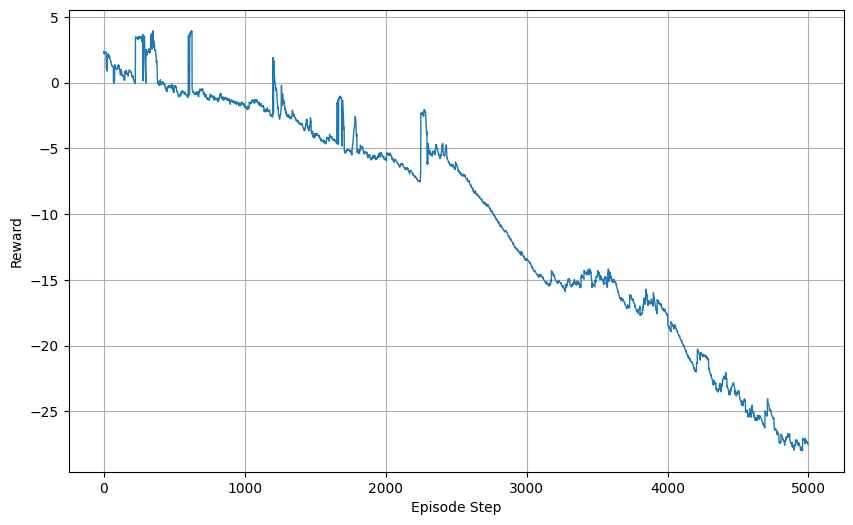

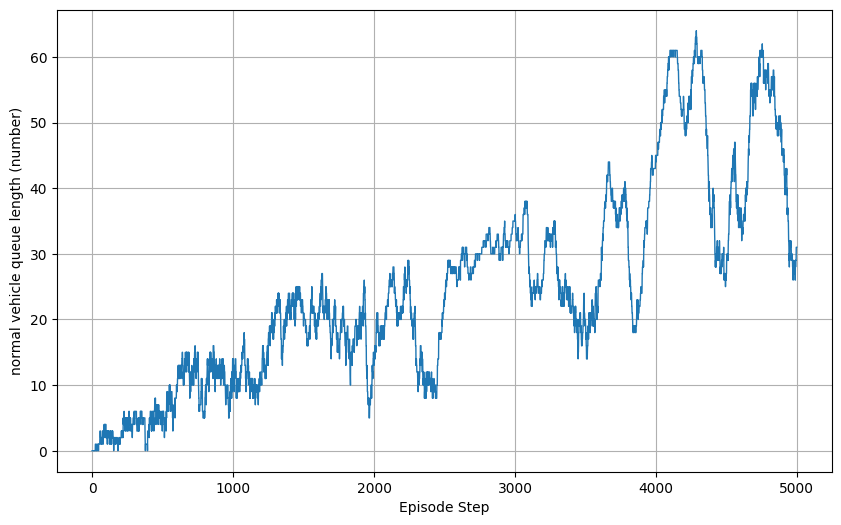

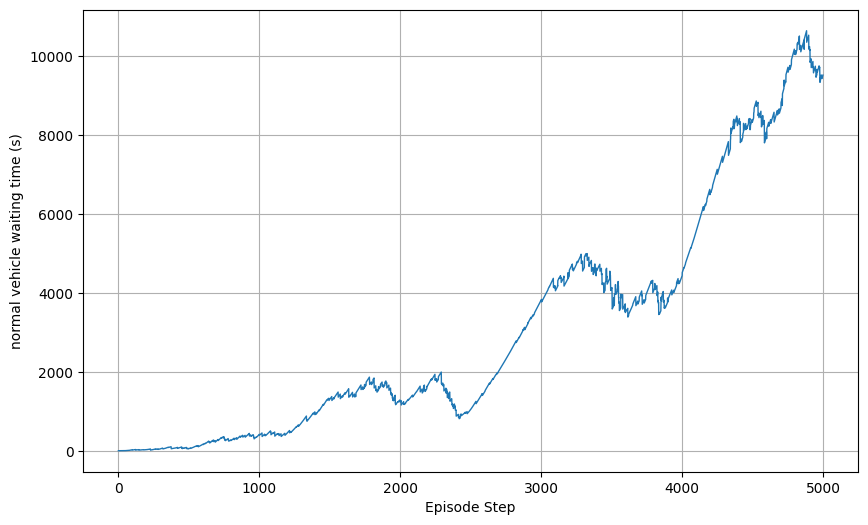

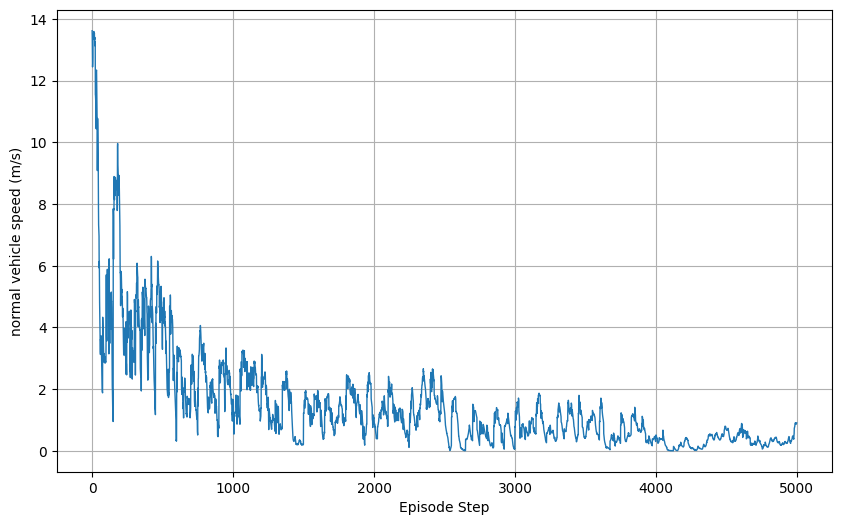

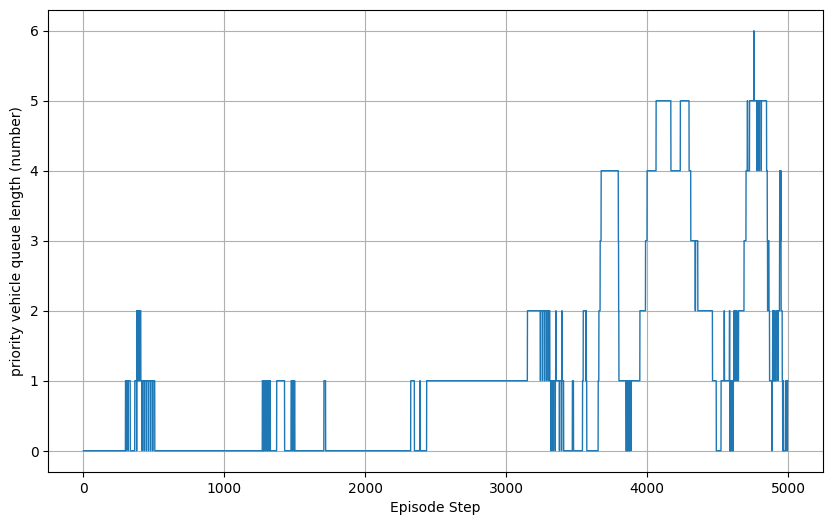

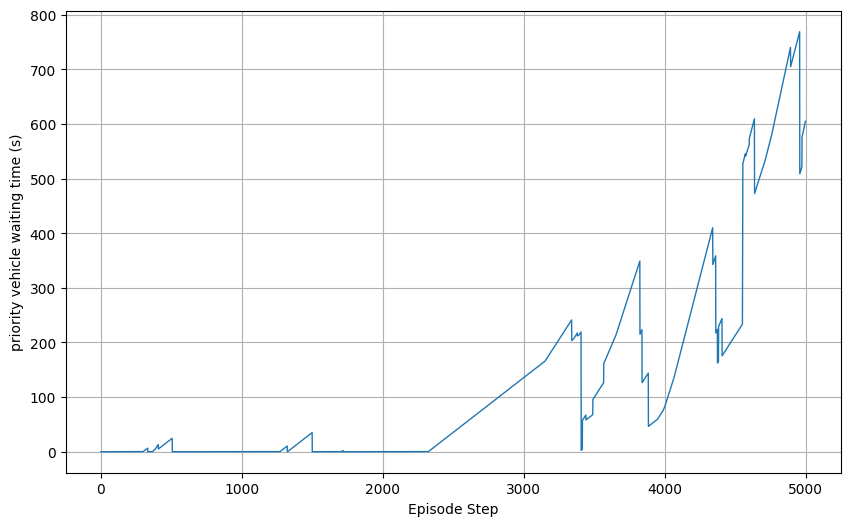

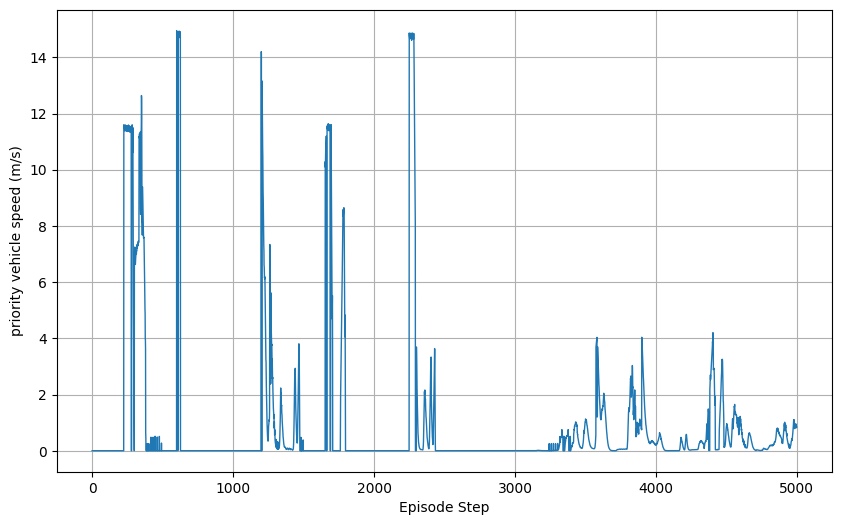

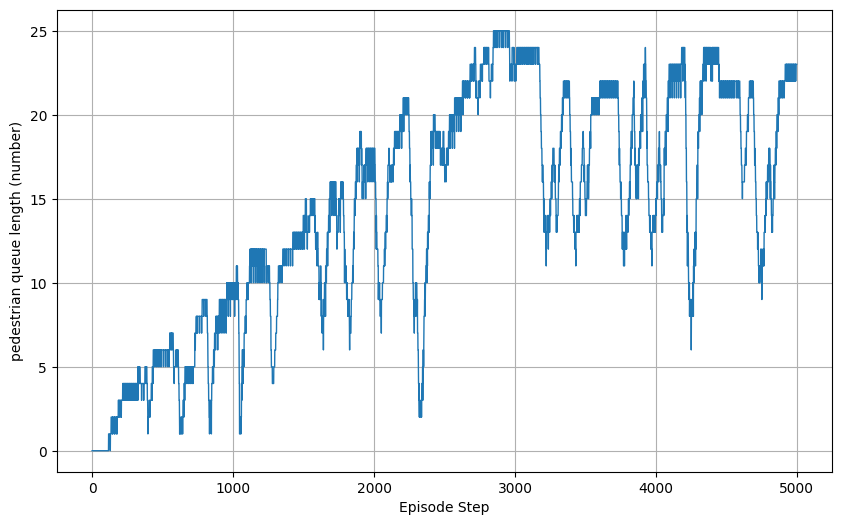

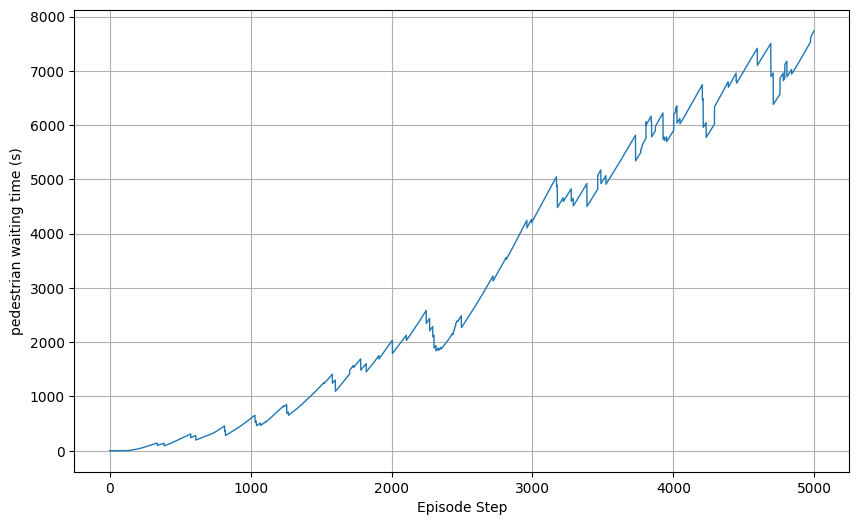

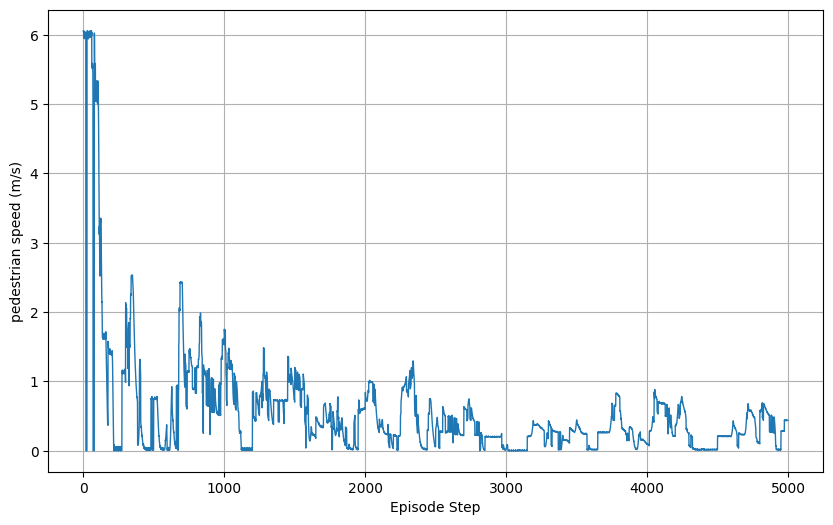

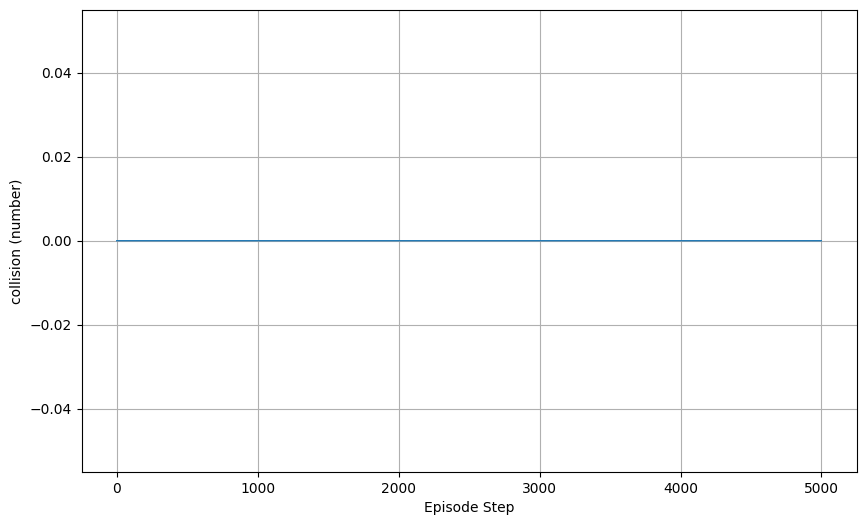

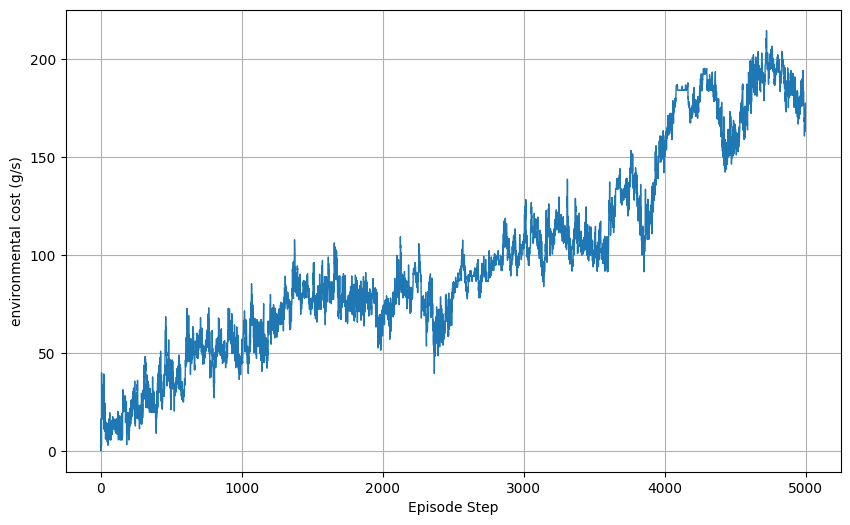

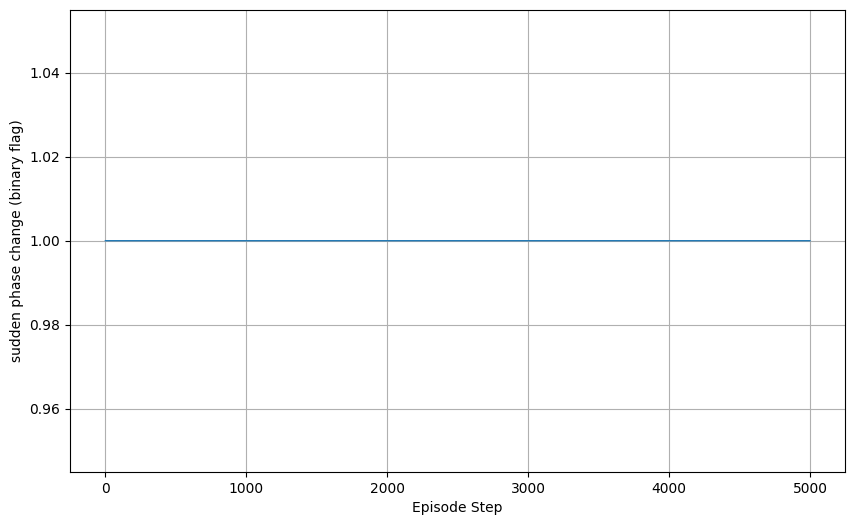

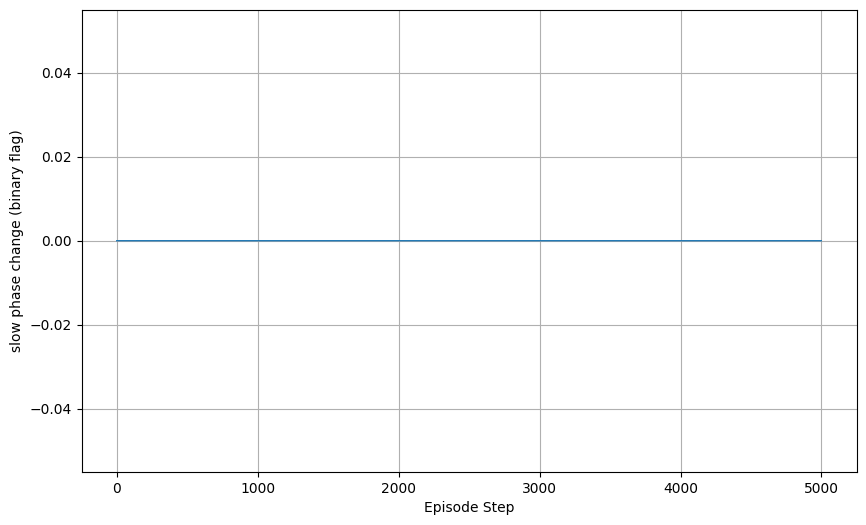

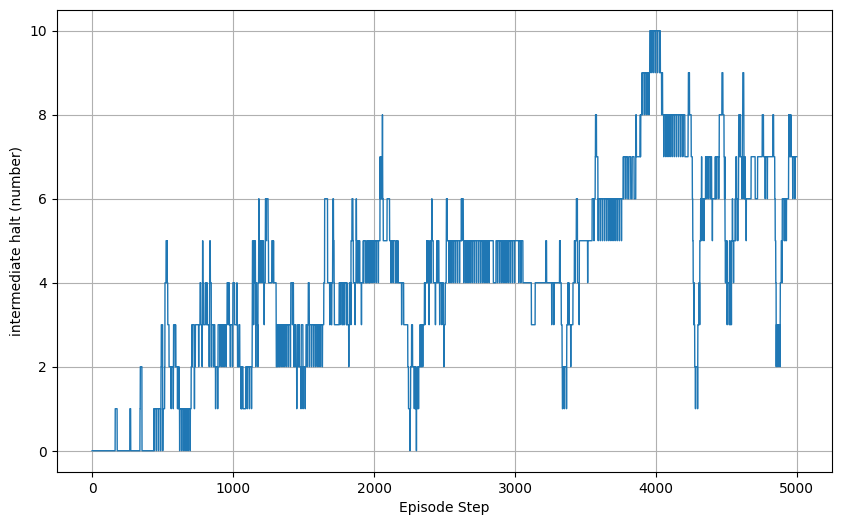

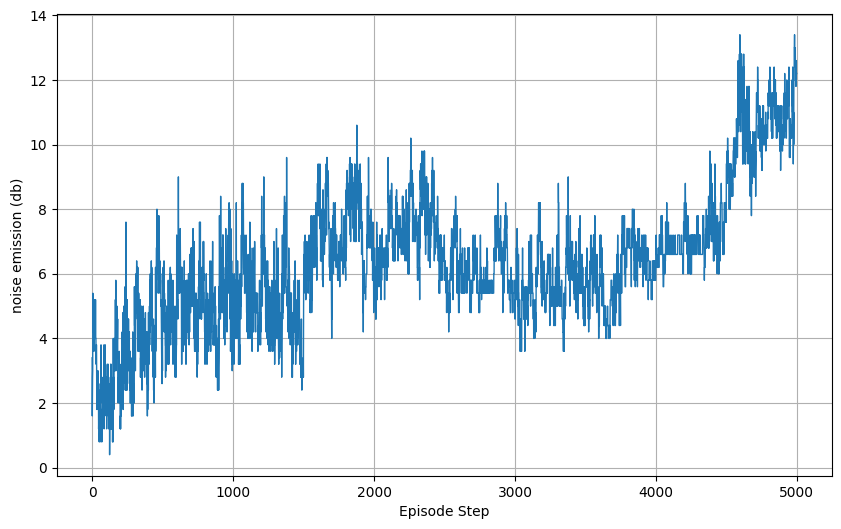

In [11]:
# Reward factor naming dictionary
naming_dict = {
    "normal_vehicle_queue_length": "normal vehicle queue length (number)",
    "normal_vehicle_waiting_time": "normal vehicle waiting time (s)",
    "normal_vehicle_speed": "normal vehicle speed (m/s)",
    "priority_vehicle_queue_length": "priority vehicle queue length (number)",
    "priority_vehicle_waiting_time": "priority vehicle waiting time (s)",
    "priority_vehicle_speed": "priority vehicle speed (m/s)",
    "pedestrian_queue_length": "pedestrian queue length (number)",
    "pedestrian_waiting_time": "pedestrian waiting time (s)",
    "pedestrian_speed": "pedestrian speed (m/s)",
    "collision": "collision (number)",
    "environmental_cost": "environmental cost (g/s)",
    "sudden_phase_change": "sudden phase change (binary flag)",
    "slow_phase_change": "slow phase change (binary flag)",
    "intermediate_halt": "intermediate halt (number)",
    "noise_emission": "noise emission (db)"
}

# Number of steps for each episode
num_steps = len(eval_data[0])

# Initialize lists to store summed values for each step
reward_sums = []
reward_factor_sums = {
    "normal_vehicle_queue_length": [],
    "normal_vehicle_waiting_time": [],
    "normal_vehicle_speed": [],
    "priority_vehicle_queue_length": [],
    "priority_vehicle_waiting_time": [],
    "priority_vehicle_speed": [],
    "pedestrian_queue_length": [],
    "pedestrian_waiting_time": [],
    "pedestrian_speed": [],
    "collision": [],
    "environmental_cost": [],
    "sudden_phase_change": [],
    "slow_phase_change": [],
    "intermediate_halt": [],
    "noise_emission": []
}
for i in range(num_steps):
    reward_sums.append(0)
    for key in reward_factor_sums:
        reward_factor_sums[key].append(0)

# Accumulate rewards and reward factors for each step across all episodes
for episode in eval_data:
    for step_index, (reward, reward_factors) in enumerate(episode):
        reward_sums[step_index] += reward
        
        for key in reward_factor_sums:
            reward_factor_sums[key][step_index] += reward_factors[key]

# Number of episodes
num_episodes = len(eval_data)

# Calculate the average for each step
average_rewards = [reward_sums[i] / num_episodes for i in range(num_steps)]

average_reward_factors = {
    key: [reward_factor_sums[key][i] / num_episodes for i in range(num_steps)]
    for key in reward_factor_sums
}

# Plotting
steps = np.arange(num_steps)  # X-axis for plotting

line_thickness = 1

# Plot average reward
plt.figure(figsize=(10, 6))
plt.plot(steps, average_rewards, linestyle='-', linewidth=line_thickness)
plt.xlabel("Episode Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Plot reward factors
for key, values in average_reward_factors.items():
    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, linestyle='-', linewidth=line_thickness)
    plt.xlabel("Episode Step")
    plt.ylabel(naming_dict[key])
    plt.grid(True)
    plt.show()

In [12]:
# Function to compute min, max, mean and sum
def compute_stats(values):
    min_value = min(values)
    max_value = max(values)
    mean_value = np.mean(values)
    cumulative_value = sum(values)
    return min_value, max_value, mean_value, cumulative_value

# Compute and print the stats for average rewards
reward_min, reward_max, reward_mean, reward_cumulative = compute_stats(average_rewards)
print("Reward - Min:", reward_min)
print("Reward - Max:", reward_max)
print("Reward - Mean:", reward_mean)
print("Reward - Cumulative:", reward_cumulative)
print("")

# Compute and print the stats for each reward factor
for key, values in average_reward_factors.items():
    factor_min, factor_max, factor_mean, factor_cumulative = compute_stats(values)
    print(f"{naming_dict[key]} - Min:", factor_min)
    print(f"{naming_dict[key]} - Max:", factor_max)
    print(f"{naming_dict[key]} - Mean:", factor_mean)
    print(f"{naming_dict[key]} - Cumulative:", factor_cumulative)
    print("")

Reward - Min: -27.988420831925318
Reward - Max: 3.9512811093724345
Reward - Mean: -10.066283356615978
Reward - Cumulative: -50331.41678307988

normal vehicle queue length (number) - Min: 0.0
normal vehicle queue length (number) - Max: 64.0
normal vehicle queue length (number) - Mean: 24.856
normal vehicle queue length (number) - Cumulative: 124280.0

normal vehicle waiting time (s) - Min: 0.0
normal vehicle waiting time (s) - Max: 10645.800000000001
normal vehicle waiting time (s) - Mean: 3071.2446800000002
normal vehicle waiting time (s) - Cumulative: 15356223.400000034

normal vehicle speed (m/s) - Min: 0.0029725472578811347
normal vehicle speed (m/s) - Max: 13.62093075
normal vehicle speed (m/s) - Mean: 1.4745748532606149
normal vehicle speed (m/s) - Cumulative: 7372.8742663030835

priority vehicle queue length (number) - Min: 0.0
priority vehicle queue length (number) - Max: 6.0
priority vehicle queue length (number) - Mean: 1.0652
priority vehicle queue length (number) - Cumulativ